### Import necessary packages

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC # SVC does not have predict_proba method
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import warnings

# import check_data

warnings.filterwarnings('ignore')

# Paths
data_path = os.path.join('..', 'data', '')
output_path = os.path.join('..', 'output', '')

# Configuration
n_splits = 5
random_seed = 42
# model_types = ['RF', 'GBDT', 'Voting', 'Averaging']
# model_types = [model_types[2]]  # Choose model type here: 'RF', 'GBDT', 'Voting', 'Averaging' # for testing


### Load the datasets

In [2]:
train_data = pd.read_csv(f"{data_path}bank_marketing_train.csv")
test_data = pd.read_csv(f"{data_path}bank_marketing_test.csv")

### Check data

In [ ]:
# check_data.check()
"""
train_data:
    'pdays' has 999 values indicating client was not previously contacted.
    'feature_1' has infinite values.
test_data:
    'campaign' has 3 null values.
    'pdays' has 999 values indicating client was not previously contacted.
    'feature_1' has infinite values and has 3 null values.
    'feature_2' has 3 null values.
"""

"\ntrain_data:\n    'pdays' has 999 values indicating client was not previously contacted.\n    'feature_1' has infinite values.\ntest_data:\n    'campaign' has 3 null values.\n    'pdays' has 999 values indicating client was not previously contacted.\n    'feature_1' has infinite values and has 3 null values.\n    'feature_2' has 3 null values.\n"

### Data preprocess

In [ ]:
def preprocess_data(df):
    categorical_columns = ['job', 'marital', 'education', 'default', 'housing',
                            'loan', 'contact', 'month', 'day_of_week', 'poutcome',
                            'feature_3', 'feature_4', 'feature_5']
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    df['pdays'] = df['pdays'].replace(999, -1)
    # Replace infinite values with median of the column
    df['feature_1'].replace([np.inf, -np.inf], df['feature_1'].median(), inplace=True)
    # Fill missing values with median
    df['campaign'].fillna(df['campaign'].median(), inplace=True)
    df['feature_1'].fillna(df['feature_1'].median(), inplace=True)
    df['feature_2'].fillna(df['feature_2'].median(), inplace=True)

preprocess_data(train_data)
preprocess_data(test_data)
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']

In [5]:
# dt = DecisionTreeClassifier(random_state=random_seed)
# dt.fit(X_train, y_train)
# y_pred = dt.predict_proba(X_train)
# assert type(y_pred) == np.ndarray
# print(y_pred.shape)

### Model definition

In [6]:
class MyEnsembleModel:
    def __init__(self, method, n_estimators, random_state=42):
        self.method = method
        self.random_state = random_state
        if n_estimators % 4 != 0:
            raise ValueError("n_estimators must be a multiple of 4")
        self.models = []
        for _ in range(n_estimators // 4):
            self.models += [
                DecisionTreeClassifier(random_state=self.random_state),
                LogisticRegression(random_state=self.random_state),
                GaussianNB(),
                KNeighborsClassifier(),
            ]
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        probas = self.predict_proba(X) # shape (n_samples, n_classes)
        assert type(probas) == np.ndarray
        preds = np.argmax(probas, axis=-1) # shape (n_samples,)
        return preds
    
    def predict_proba(self, X):
        probas = np.zeros((len(self.models), X.shape[0], 2)) # shape (n_models, n_samples, n_classes)
        for i, model in enumerate(self.models):
            proba = model.predict_proba(X) # shape (n_samples, n_classes)
            probas[i] = proba
        
        if self.method == 'voting':
            votes = (probas >= 0.5).astype(int) # shape (n_models, n_samples, n_classes)
            return np.sum(votes, axis=0) / len(self.models) # shape (n_samples, n_classes)
        
        elif self.method == 'averaging':
            return np.mean(probas, axis=0)
        
        else:
            raise ValueError("Method cannot be found!")
    
    def score(self, X, y):
        preds = self.predict(X) == 'yes'
        y_label = np.array(y) == 'yes'
        return accuracy_score(y_label, preds)

### Init models

In [ ]:
# init models
model = {}
model['RF'] = RandomForestClassifier(n_estimators=100, random_state=random_seed)
model['GBDT'] = GradientBoostingClassifier(n_estimators=100, random_state=random_seed)
model['Voting'] = MyEnsembleModel(n_estimators=100, method='voting', random_state=random_seed)
model['Averaging'] = MyEnsembleModel(n_estimators=100, method='averaging', random_state=random_seed)

### Training

Training model: RF
    Validation score for fold 1: 0.8853
    AUC for fold 1: 0.7722
    Validation score for fold 2: 0.8884
    AUC for fold 2: 0.7789
    Validation score for fold 3: 0.8868
    AUC for fold 3: 0.7599
    Validation score for fold 4: 0.8895
    AUC for fold 4: 0.7749
    Validation score for fold 5: 0.8897
    AUC for fold 5: 0.7752
    Mean AUC: 0.7722
Training model: GBDT
    Validation score for fold 1: 0.8914
    AUC for fold 1: 0.7971
    Validation score for fold 2: 0.8945
    AUC for fold 2: 0.8078
    Validation score for fold 3: 0.8943
    AUC for fold 3: 0.7928
    Validation score for fold 4: 0.8985
    AUC for fold 4: 0.7942
    Validation score for fold 5: 0.8950
    AUC for fold 5: 0.8016
    Mean AUC: 0.7987
Training model: Voting
    Validation score for fold 1: 0.8810
    AUC for fold 1: 0.6968
    Validation score for fold 2: 0.8811
    AUC for fold 2: 0.7293
    Validation score for fold 3: 0.8811
    AUC for fold 3: 0.7068
    Validation score for

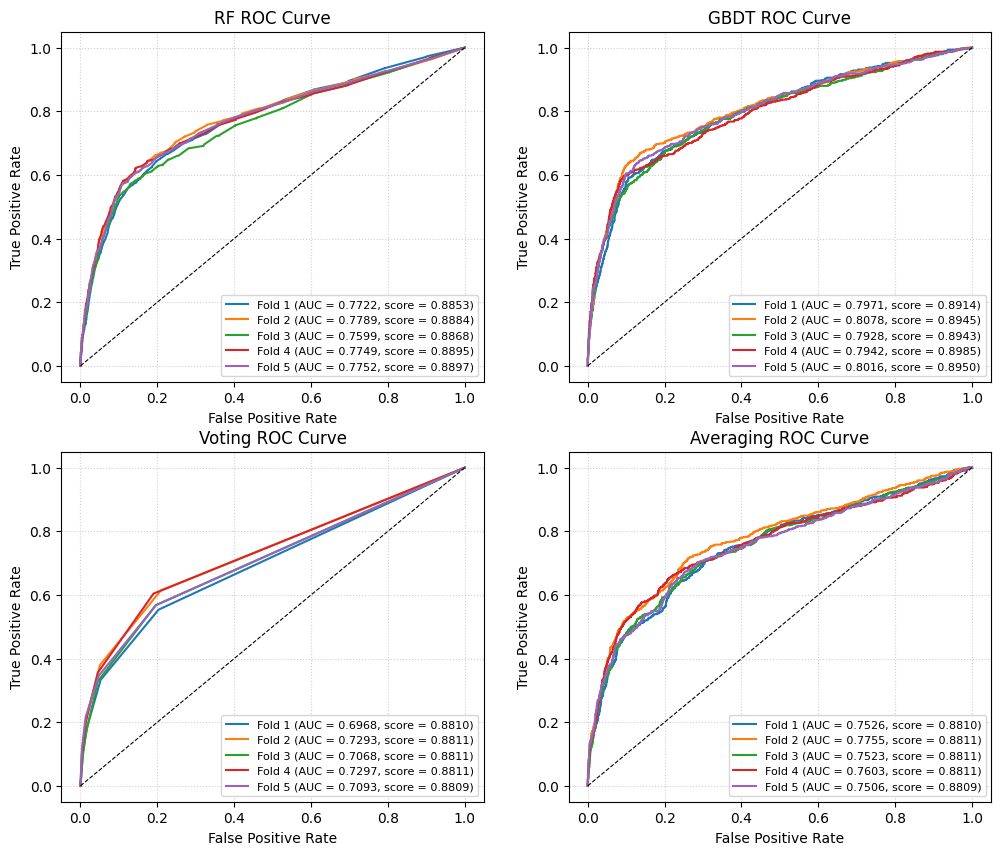

In [ ]:
fig, axes = plt.subplots((len(model) + 1) // 2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, model_type in enumerate(model.keys()):
    print(f'Training model: {model_type}')
    # plt.close()  # Close the current figure to avoid overlap in plots
    ax = axes[idx]

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    auc = []

    for i, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
        # training and validation
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        model[model_type].fit(X_train_fold, y_train_fold)
        score = model[model_type].score(X_val_fold, y_val_fold)
        print(f"    Validation score for fold {i + 1}: {score:.4f}")

        # calculate AUC
        y_label = np.array(y_val_fold) == 'yes'
        y_val_pred_prob = model[model_type].predict_proba(X_val_fold)
        assert type(y_val_pred_prob) == np.ndarray
        y_val_pred_prob = y_val_pred_prob[:, 1]
        auc.append(roc_auc_score(y_label, y_val_pred_prob))
        print(f"    AUC for fold {i + 1}: {auc[i]:.4f}")

        # plot ROC curve
        fpr, tpr, thresholds = roc_curve(y_label, y_val_pred_prob)
        # plt.plot(fpr, tpr, label=f'Fold {i + 1} (AUC = {auc[i]:.4f}, score = {score:.4f})')
        ax.plot(fpr, tpr, label=f'Fold {i + 1} (AUC = {auc[i]:.4f}, score = {score:.4f})')

    print(f'    Mean AUC: {np.mean(auc):.4f}')
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_type} ROC Curve')
    ax.legend(fontsize=8)
    ax.grid(True, linestyle=':', alpha=0.6)

plt.savefig(f'{output_path}ensamble_model_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

### Testing

In [ ]:
for model_type in model.keys():
    # pred = model.predict(test_data)
    pred_prob = model[model_type].predict_proba(test_data)
    assert type(pred_prob) == np.ndarray
    pred_prob = pred_prob[:, 1]
    pd.DataFrame(pred_prob).to_csv(f'{output_path}{model_type}_test_scores.csv', index=False, header=False)